[*********************100%***********************]  1 of 1 completed


1 Bullish FVGs Trades taken
Bull FVG 5 Period Average returns: -3.36%
Bull FVG Win Rate: 0.0%
1 Medium Sized Bullish FVGs
Medium Bull FVG 5 Period Average returns: -3.36%
Medium Bull FVG Win Rate: 0.0%
2 Bearish FVGS Trades Taken
Bear FVG 5 Period Average returns: -0.89%
Bear FVG Win Rate: 50.0%
0 Medium Sized Bearish FVGs
Medium Bear FVG 5 Period Average returns: nan%
Medium Bear FVG Win Rate: nan%


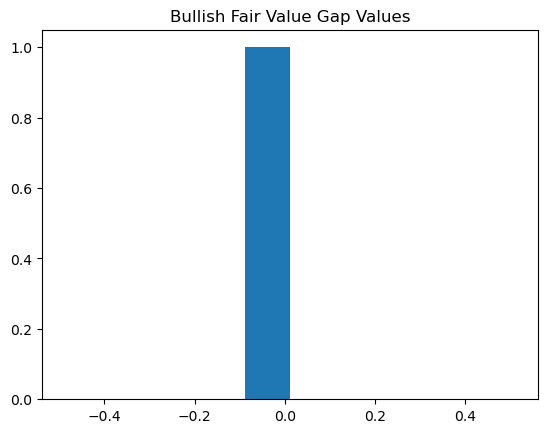

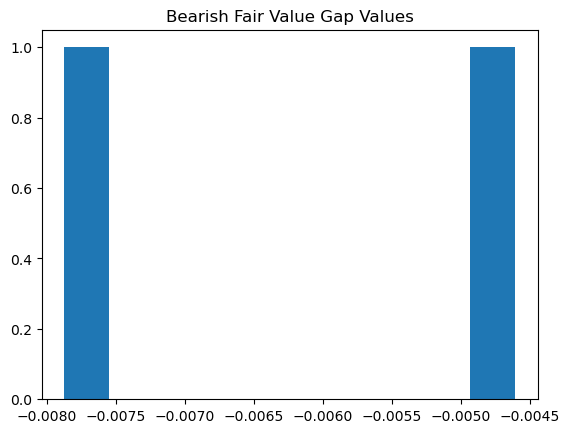

In [39]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- GLOBAL PARAMETERS ---
TICKER = 'SPY'
LOOKBACK = 10000 
HOLDING_PERIOD = 5 # Days to hold the position
STD_DEV_FACTOR = 2 # Added for potential future use

# --- 1. DATA RETRIEVAL (GET DATA) ---

def get_data(ticker=TICKER):
    # Downloads data, using auto_adjust=True to account for splits and dividends. 
    # This ensures accurate return calculations.
    df = yf.download(ticker, auto_adjust=True) 

    # Removes the top level of column headers. Necessary if downloading multiple tickers.
    # In this case (single ticker), it is redundant but harmless.
    df.columns = df.columns.get_level_values(0) 

    # Returns the last LOOKBACK rows. This slice should ideally be done AFTER all
    # forward-looking calculations (like the returns in assess_FVG).
    return df.iloc[-LOOKBACK:, :] 

# --- 2. BULLISH FVG (Fair Value Gap) ---

def bull_fvg(df):
    # Calculates the high price from 2 days ago. Used to identify the gap.
    df['High_2prev'] = df['High'].shift(2)
    
    # Checks for Bullish FVG: Current Low Price > High Price 2 Days Ago.
    # If True, the gap exists, and the value is set to 1 (otherwise 0).
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    
    # Calculates the size of the FVG, normalized by the current Close price.
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    # Subsets the data to include only dates where the FVG occurred and the value is positive.
    fvg_subset = df[df['Bull_FVG_Val'] > 0] 

    # Plots the distribution of the FVG sizes.
    plt.figure()
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10)
    plt.title('Bullish Fair Value Gap Values')

    return df # Returns the DataFrame with new columns added

# --- 3. BEARISH FVG ---

def bear_fvg(df):
    # Calculates the low price from 2 days ago. Used to identify the gap.
    df['Low_2prev'] = df['Low'].shift(2)
    
    # Checks for Bearish FVG: Current High Price < Low Price 2 Days Ago.
    # If True, the gap exists, and the value is set to 1 (otherwise 0).
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    
    # Calculates the size of the FVG. The value will be negative.
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    # Subsets the data to include only dates where the FVG occurred and the value is negative.
    fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10)
    plt.title('Bearish Fair Value Gap Values')

    return df # Returns the DataFrame with new columns added

# --- 4. ASSESS BULLISH FVG ---

def assess_bull_FVG(df, holding_period=HOLDING_PERIOD):

    
    # Calculates the return over the holding period: Future Close / Current Close.
    # We use df['Close'] here, assuming auto_adjust=True was used in get_data.
    df[f'Returns_In_{holding_period}_Periods'] = df['Close'].shift(-holding_period) / df['Close']
    
    # Selects all rows where a Bullish FVG occurred.
    fvg_subset = df[df['Bull_FVG_Val'] > 0]
    
    # CORRECTED: Quote nesting fixed (using double quotes for the print string)
    print(f"{len(fvg_subset)} Bullish FVGs Trades taken")
    
    # Calculates average return: converts growth factor (e.g., 1.05) to percentage return (e.g., 5.0%).
    # CORRECTED: Quote nesting fixed
    avg_return = round((fvg_subset[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)
    print(f"Bull FVG {holding_period} Period Average returns: {avg_return}%")

    # Win Rate: For a Bullish (Long) trade, a win is when the final price is > entry price.
    # Returns_In... > 1 means the price went up.
    win_rate = (fvg_subset[f'Returns_In_{holding_period}_Periods'] > 1).mean() * 100 # FIX: Win is > 1 for long
    print(f'Bull FVG Win Rate: {round(win_rate, 2)}%')

    # define quantiles (Used to find the size of the FVG for the middle 50% of events)
    lower = fvg_subset['Bull_FVG_Val'].quantile(.25)
    upper = fvg_subset['Bull_FVG_Val'].quantile(.75)

    # subset rows where the FVG value is within the middle 50% range.
    fvg_medium_val = fvg_subset[
        (fvg_subset['Bull_FVG_Val'] >= lower) & (fvg_subset['Bull_FVG_Val'] <= upper)
    ]
    print(f'{len(fvg_medium_val)} Medium Sized Bullish FVGs')
    
    # Calculate returns and win rate for medium-sized FVGs
    avg_return_medium = round((fvg_medium_val[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)
    print(f'Medium Bull FVG {holding_period} Period Average returns: {avg_return_medium}%')

    win_rate_medium = (fvg_medium_val[f'Returns_In_{holding_period}_Periods'] > 1).mean() * 100 # FIX: Win is > 1 for long
    print(f'Medium Bull FVG Win Rate: {round(win_rate_medium, 2)}%')

    return df

# --- 5. ASSESS BEARISH FVG ---

def assess_bear_FVG(df, holding_period=HOLDING_PERIOD):
    # Calculates the return over the holding period: Future Close / Current Close.
    df[f'Returns_In_{holding_period}_Periods'] = df['Close'].shift(-holding_period) / df['Close']
    
    # Selects all rows where a Bearish FVG occurred.
    fvg_subset = df[df['Bear_FVG_Val'] < 0]
    
    # FIX: Quote nesting fixed
    print(f"{len(fvg_subset)} Bearish FVGS Trades Taken")
    
    # Calculates average return: converts growth factor to percentage return.
    avg_return = round((fvg_subset[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)
    print(f"Bear FVG {holding_period} Period Average returns: {avg_return}%")

    # Win Rate: For a Bearish (Short) trade, a win is when the price goes DOWN.
    # Returns_In... < 1 means the final price was lower than the entry price.
    win_rate = (fvg_subset[f'Returns_In_{holding_period}_Periods'] < 1).mean() * 100 # FIX: Win is < 1 for short
    print(f'Bear FVG Win Rate: {round(win_rate, 2)}%')

    # define quantiles
    lower = fvg_subset['Bear_FVG_Val'].quantile(.25)
    upper = fvg_subset['Bear_FVG_Val'].quantile(.75)

    # subset
    fvg_medium_val = fvg_subset[
        (fvg_subset['Bear_FVG_Val'] >= lower) & (fvg_subset['Bear_FVG_Val'] <= upper)
    ]
    print(f'{len(fvg_medium_val)} Medium Sized Bearish FVGs')
    
    # Calculate returns and win rate for medium-sized FVGs
    avg_return_medium = round((fvg_medium_val[f'Returns_In_{holding_period}_Periods'].mean() - 1) * 100, 2)
    print(f'Medium Bear FVG {holding_period} Period Average returns: {avg_return_medium}%')

    win_rate_medium = (fvg_medium_val[f'Returns_In_{holding_period}_Periods'] < 1).mean() * 100 # FIX: Win is < 1 for short
    print(f'Medium Bear FVG Win Rate: {round(win_rate_medium, 2)}%')

    return df

# --- 6. MAIN EXECUTION ---

def main():
    # Execute the functions sequentially, passing the DataFrame along
    df = get_data()
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = assess_bull_FVG(df)
    df = assess_bear_FVG(df)
    # The final step is to drop rows that do not have return data (due to the shift)
    df.dropna(inplace=True)
    return df

df = main()

In [40]:
df["Bear_FGV"].value_counts()

KeyError: 'Bear_FGV'

In [ ]:
df["Bull_FGV"].value_counts()

Bull_FGV
0    379
1    121
Name: count, dtype: int64